# Brunswick GA, USA, Historical Weather Analysis
## Exploring the past with daily weather summaries

Why [Brunswick](https://en.wikipedia.org/wiki/Brunswick,_Georgia)? Because Colleen's colleages have some projects on nearby St. Simons and she might as well have an excuse to join them. At least we can put a veneer of scientific and academic respectabiliy on a trip to the beach, eh? 

Brunswick has a farily long history as a port. See its [wikipedia entry](https://en.wikipedia.org/wiki/History_of_Brunswick,_Georgia). Weather is always interesting to mariners so we have pretty good records. There we plantations nearby, so I hope I can find some commodity prices and correlate them with the weather. It might not be very interesting, but it'll be a good exercise.

Our dataset is all available daily weather summaries for the Bunswick, GA weather station. I download the data from https://www.ncdc.noaa.gov. The records begin in the 1890s, but I don't know if there are gaps. We'll soon find out.

### Part the First: Clean up the data

Some preliminaries:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

Now we can load the data. This could be done with the climate data [API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2), but since this is just for one station I won't do that. I've put the raw data as received on my server for easy access.

In [7]:
wx = pd.read_csv('http://rentrof.net/pyproj/brunswick_wx_daily_records.csv', 
                 na_values=[-9999,9999, 'unknown'],
                index_col='DATE',
                parse_dates=True,
                low_memory=False)

In [8]:
wx.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,MDPR,Measurement Flag,Quality Flag,Source Flag,Time of Observation,...,WT08,Measurement Flag.15,Quality Flag.15,Source Flag.15,Time of Observation.15,WT03,Measurement Flag.16,Quality Flag.16,Source Flag.16,Time of Observation.16
DATE,,,,,,,,,,,,,,,,,,,,,
1895-01-01,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,,,,NaN,...,NaN,,,,NaN,NaN,,,,NaN
1895-01-02,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,,,,NaN,...,NaN,,,,NaN,NaN,,,,NaN
1895-01-03,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,,,,NaN,...,NaN,,,,NaN,NaN,,,,NaN
1895-01-04,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,,,,NaN,...,NaN,,,,NaN,NaN,,,,NaN
1895-01-05,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,,,,NaN,...,NaN,,,,NaN,NaN,,,,NaN


We've got a bunch of columns we don't need.

In [10]:
wx.columns

Index(['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'MDPR',
       'Measurement Flag', 'Quality Flag', 'Source Flag',
       'Time of Observation', 'DAPR', 'Measurement Flag.1', 'Quality Flag.1',
       'Source Flag.1', 'Time of Observation.1', 'PRCP', 'Measurement Flag.2',
       'Quality Flag.2', 'Source Flag.2', 'Time of Observation.2', 'SNWD',
       'Measurement Flag.3', 'Quality Flag.3', 'Source Flag.3',
       'Time of Observation.3', 'SNOW', 'Measurement Flag.4', 'Quality Flag.4',
       'Source Flag.4', 'Time of Observation.4', 'TMAX', 'Measurement Flag.5',
       'Quality Flag.5', 'Source Flag.5', 'Time of Observation.5', 'TMIN',
       'Measurement Flag.6', 'Quality Flag.6', 'Source Flag.6',
       'Time of Observation.6', 'TOBS', 'Measurement Flag.7', 'Quality Flag.7',
       'Source Flag.7', 'Time of Observation.7', 'WT14', 'Measurement Flag.8',
       'Quality Flag.8', 'Source Flag.8', 'Time of Observation.8', 'WT01',
       'Measurement Flag.9', 'Qual

Looks like we can get rid of most of these. The long names with spaces aren't useful so we'll filter them out:

In [11]:
wx = wx.filter(regex='^\S*$', axis=1)
wx.columns

Index(['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'MDPR',
       'DAPR', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'TOBS', 'WT14', 'WT01',
       'WT06', 'WT05', 'WT11', 'WT04', 'WT16', 'WT08', 'WT03'],
      dtype='object')

We need descriptive column names. Here's a dictionary that maps the weather type codes to useful names. This is based on the Global Historical Climatology Network [documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)

In [12]:
new_cols = {
 'WT01': 'fog_ice',
 'WT02': 'fog_hvy',
 'WT03': 'thunder',
 'WT04': 'sleet',
 'WT05': 'hail',
 'WT06': 'rime',
 'WT07': 'dust',
 'WT08': 'smoke',
 'WT09': 'snow',
 'WT10': 'tornado',
 'WT11': 'hi_wind',
 'WT12': 'spray',
 'WT13': 'mist',
 'WT14': 'drizzle',
 'WT15': 'drizzle_frz',
 'WT16': 'rain',
 'WT17': 'snow',
 'WT18': 'precip_unknown'}

wx.rename(columns=new_cols, inplace=True)
wx.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,MDPR,DAPR,PRCP,SNWD,SNOW,...,TOBS,drizzle,fog_ice,rime,hail,hi_wind,sleet,rain,smoke,thunder
DATE,,,,,,,,,,,,,,,,,,,,,
1895-01-01,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895-01-02,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895-01-03,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895-01-04,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895-01-05,GHCND:USC00091340,BRUNSWICK GA US,4.6,31.15,-81.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Do the Station name or Station ID vary?

In [13]:
wx.STATION.unique().size

1

In [14]:
wx.STATION_NAME.unique().size

1

Nope. They're the same throughout so we'll drop those columns:

In [15]:
wx.drop(['STATION', 'STATION_NAME'],axis=1,inplace=True)

#### Now let's look for unreasonable temperatures

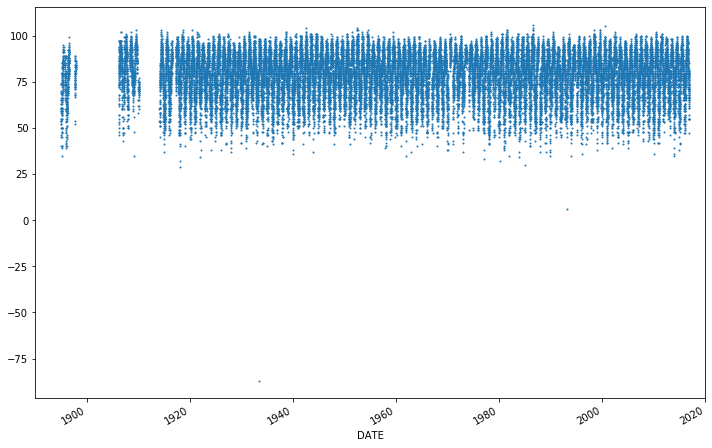

In [17]:
wx.TMAX.plot(style='o', ms=1, xlim=('1890', '2020'))

That antarctic temp around 1933 is ridiculous. Perhaps there's just an errant negative sign.

In [18]:
'The lowest TMAX in the dataset is {} degrees that occured on {}'.format(wx.TMAX.min(), wx.TMAX.idxmin().strftime('%a %d-%b-%Y'))

'The lowest TMAX in the dataset is -87.0 degrees that occured on Tue 16-May-1933'

Lets look at the surrounding days and see if this is a screwy negative sign:

In [19]:
days_around = pd.Timedelta('5 days')
wx.loc[wx.TMAX.idxmin() - days_around : wx.TMAX.idxmin() + days_around][['TMAX','TMIN']]

,TMAX,TMIN
DATE,,
1933-05-11,89.0,72.0
1933-05-12,90.0,72.0
1933-05-13,89.0,71.0
1933-05-14,94.0,72.0
1933-05-15,92.0,70.0
1933-05-16,-87.0,72.0
1933-05-17,94.0,70.0
1933-05-18,78.0,72.0
1933-05-19,82.0,67.0


Yep. Based on the surrounding days, I don't think (positive) 87 degrees is unreasonable. I'll remove the negative sign from this entry:

In [20]:
wx.loc['1933-05-16', 'TMAX'] *= -1 #toggle sign

#### Try this differently: use `.nlargest` and `.nsmallest`

In [21]:
wx.TMAX.nsmallest(), wx.TMAX.nlargest()

(DATE
 1993-04-07     6.0
 1917-12-30    29.0
 1985-01-22    30.0
 1917-12-31    32.0
 1980-03-03    32.0
 Name: TMAX, dtype: float64,
 DATE
 1986-07-21    106.0
 2000-07-20    105.0
 1942-07-21    104.0
 1952-06-25    104.0
 1986-07-20    104.0
 Name: TMAX, dtype: float64)

Those look reasonable to me. April of 1993 sure was cold. 

Now let's look at TMIN:

In [22]:
wx.TMIN.nsmallest(), wx.TMIN.nlargest()

(DATE
 1948-05-16   -65.0
 1966-01-30     5.0
 1985-01-21     5.0
 1983-12-25    11.0
 1895-02-08    13.0
 Name: TMIN, dtype: float64,
 DATE
 2005-08-17    97.0
 2000-08-18    95.0
 2004-05-29    93.0
 1982-06-28    92.0
 1908-08-03    88.0
 Name: TMIN, dtype: float64)

That negative 65 in 1948 is not right. Let's look around it and see if this is another sign error.

In [23]:
wx.loc[wx.TMIN.idxmin() - days_around : wx.TMIN.idxmin() + days_around][['TMAX','TMIN']]

,TMAX,TMIN
DATE,,
1948-05-11,81.0,70.0
1948-05-12,82.0,68.0
1948-05-13,90.0,67.0
1948-05-14,87.0,69.0
1948-05-15,88.0,62.0
1948-05-16,86.0,-65.0
1948-05-17,91.0,67.0
1948-05-18,90.0,71.0
1948-05-19,83.0,67.0


Yep. Probably a misplaced negative sign. 65 degrees for a low in April is reasonable. Toggle that sign:

In [24]:
wx.loc['1948-05-16', 'TMIN'] *= -1 #toggle sign

Another look at those temps now that we've cleaned them up:

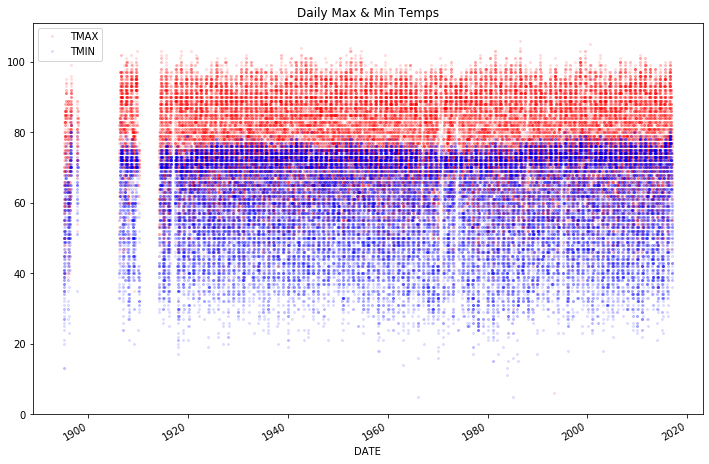

In [25]:
wx[['TMAX', 'TMIN']].plot(style=['ro', 'bo'], ms=2, alpha=0.1, title='Daily Max & Min Temps')

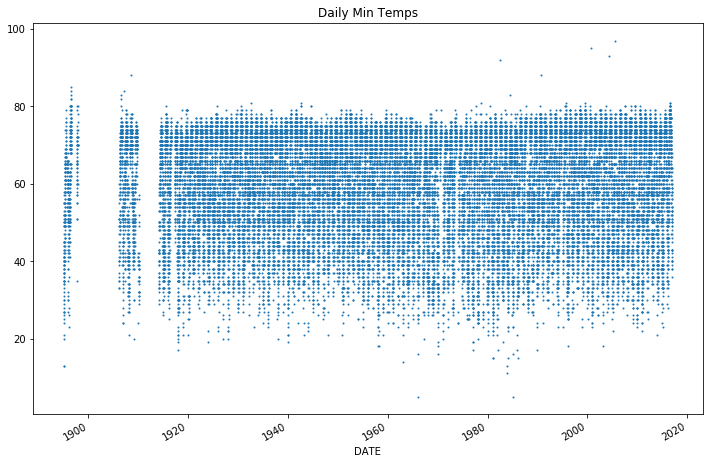

In [26]:
wx.TMIN.plot(style='o', ms=1, title='Daily Min Temps')

Seems most of those weather type columns (rain, drizzle, etc.) are NaN. Let's see what a plot looks like

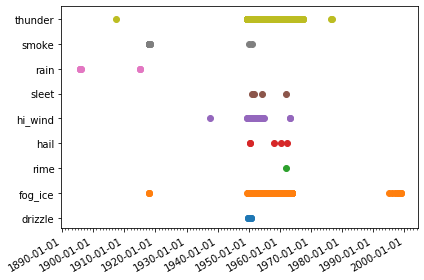

In [45]:
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots()
cols = wx.columns[11:]
labels = cols.tolist()

for i,col in enumerate(cols):
    ax.scatter(x=wx[col].index, y=(wx[col]+i))  # add a little to each so the dots have y separation

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
#ax.set_xlim('1890', '2020')
labels.insert(0,'no')  # set_yticklabels needs an offset list for some reason
ax.set_yticklabels(labels)
fig.autofmt_xdate()
fig.tight_layout()

Why was there so much thunder in the 1950s and 1960s? There also seems to be a great density of other observations during the '50s and '60s as well. I wonder if this correlates with the career of one person (maybe a WWII veteran?) who was meticulous about weather type observations. 

**This is a great place for data and history to intersect.**

Find the rows where there are any weather type entries:

In [34]:
wx[wx.loc[:,'drizzle':].any(axis=1)]

,ELEVATION,LATITUDE,LONGITUDE,MDPR,DAPR,PRCP,SNWD,SNOW,TMAX,TMIN,TOBS,drizzle,fog_ice,rime,hail,hi_wind,sleet,rain,smoke,thunder
DATE,,,,,,,,,,,,,,,,,,,,
1895-10-11,4.6,31.15000,-81.50000,NaN,NaN,NaN,NaN,NaN,78.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1895-10-12,4.6,31.15000,-81.50000,NaN,NaN,NaN,NaN,NaN,73.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1895-11-01,4.6,31.15000,-81.50000,NaN,NaN,NaN,NaN,NaN,65.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1895-11-09,4.6,31.15000,-81.50000,NaN,NaN,NaN,NaN,NaN,89.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1895-12-10,4.6,31.15000,-81.50000,NaN,NaN,0.55,NaN,NaN,55.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-12-19,4.0,31.16667,-81.50000,NaN,NaN,0.00,0.0,0.0,69.0,41.0,46.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-22,4.0,31.16667,-81.50000,NaN,NaN,0.07,0.0,0.0,76.0,59.0,68.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-21,4.0,31.16806,-81.50222,NaN,NaN,0.00,0.0,0.0,77.0,55.0,64.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
wx[wx.hi_wind.notnull()]

,ELEVATION,LATITUDE,LONGITUDE,MDPR,DAPR,PRCP,SNWD,SNOW,TMAX,TMIN,TOBS,drizzle,fog_ice,rime,hail,hi_wind,sleet,rain,smoke,thunder
DATE,,,,,,,,,,,,,,,,,,,,
1937-08-18,3.0,31.133333,-81.5,NaN,NaN,0.00,0.0,0.0,82.0,73.0,81.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1949-07-15,3.0,31.150000,-81.5,NaN,NaN,0.06,0.0,0.0,93.0,76.0,84.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1949-08-13,3.0,31.150000,-81.5,NaN,NaN,0.01,0.0,0.0,87.0,76.0,83.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1949-10-01,3.0,31.150000,-81.5,NaN,NaN,0.00,0.0,0.0,78.0,68.0,75.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1949-10-02,3.0,31.150000,-81.5,NaN,NaN,0.00,0.0,0.0,81.0,70.0,75.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954-04-17,3.0,31.150000,-81.5,NaN,NaN,0.00,0.0,0.0,72.0,53.0,69.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1954-06-20,3.0,31.150000,-81.5,NaN,NaN,0.80,0.0,0.0,85.0,70.0,80.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1955-01-13,3.0,31.150000,-81.5,NaN,NaN,0.00,0.0,0.0,60.0,45.0,49.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


Precipitation data looks reasonable:

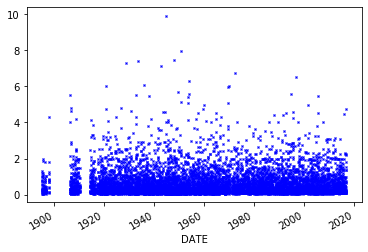

In [39]:
wx.loc[wx.PRCP > 0.05, 'PRCP'].plot(style='bx', ms='2')  # get rid of zeroes and trace amounts

In [24]:
wx.PRCP.nlargest(10), wx[wx.PRCP !=0].PRCP.nsmallest(10) #smallest that's not zero

(DATE
 1944-10-19    9.92
 1950-09-06    7.93
 1947-09-23    7.47
 1933-09-05    7.42
 1928-09-18    7.30
 1942-08-12    7.10
 1972-06-19    6.75
 1996-10-07    6.53
 1953-09-26    6.30
 1935-09-18    6.08
 Name: PRCP, dtype: float64, DATE
 1895-01-18    0.01
 1895-03-03    0.01
 1906-05-16    0.01
 1906-12-28    0.01
 1914-07-13    0.01
 1914-10-13    0.01
 1914-12-04    0.01
 1915-03-01    0.01
 1915-08-14    0.01
 1915-10-11    0.01
 Name: PRCP, dtype: float64)

All the graphs above show there are some gaps in the data record: there's big gap in the late 1800s and another around 1910.

Should I re-index with a complete date range? I'm not sure that's very helpful, but it might be a good exercise anyway:

We can use `np.setdiff1d` to find the dates that are missing from the index

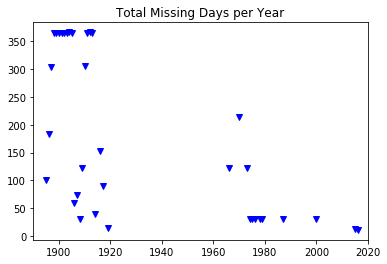

In [55]:
full_index = pd.date_range(wx.index.min(), wx.index.max()) #index object with each day from start to end
missing_dates = pd.DataFrame(
                            index=np.setdiff1d(full_index, wx.index),   # find dates missing in wx index
                            data={'missing':True})   # indicator column, don't really need this
missing_dates.groupby(missing_dates.index.year)\
                .sum()\
                .plot(style='bv',
                      legend=None, 
                      title='Total Missing Days per Year', 
                      xlim=(1890, 2020))

We can also summarize by the decade

In [89]:
missing_dates.groupby(((missing_dates.index.year//10)*10)).sum() # integer division then mult by 10 to get decade.

,missing
1890,1318.0
1900,2478.0
1910,1698.0
1960,122.0
1970,490.0
1980,30.0
2000,30.0
2010,24.0


In [95]:
missing_dates.groupby(missing_dates.index.year).sum()

,missing
1895,100.0
1896,184.0
1897,304.0
1898,365.0
1899,365.0
1900,365.0
1901,365.0
1902,365.0
1903,365.0
1904,366.0


In [48]:
wx.index.max()

Timestamp('2016-12-31 00:00:00')

In [49]:
## Uncomment if you want a dataset with the missing dates filled in

#full_index = pd.date_range(wx.index.min(), wx.index.max())#full date range from start of wx data
#wx = wx.reindex(full_index, method=None) #reindex the wx df

In [50]:
wx.to_csv('brunswick_wx_processed.csv')

In [51]:
wx.dropna(subset=['TMAX','TMIN','TOBS']).loc[~(wx.TOBS.between(wx.TMIN, wx.TMAX))]

,ELEVATION,LATITUDE,LONGITUDE,MDPR,DAPR,PRCP,SNWD,SNOW,TMAX,TMIN,TOBS,drizzle,fog_ice,rime,hail,hi_wind,sleet,rain,smoke,thunder
DATE,,,,,,,,,,,,,,,,,,,,
1906-09-17,4.6,31.1500,-81.5000,NaN,NaN,0.00,NaN,NaN,82.0,76.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-11-07,4.6,31.1500,-81.5000,NaN,NaN,0.00,NaN,NaN,75.0,53.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-12-31,4.6,31.1500,-81.5000,NaN,NaN,0.36,NaN,NaN,72.0,56.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907-03-19,4.6,31.1500,-81.5000,NaN,NaN,0.00,NaN,NaN,84.0,84.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1908-01-28,4.6,31.1500,-81.5000,NaN,NaN,0.62,NaN,NaN,70.0,39.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-17,4.0,31.1681,-81.5022,NaN,NaN,0.00,0.0,0.0,98.0,97.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-23,4.0,31.1681,-81.5022,NaN,NaN,0.00,0.0,0.0,48.0,48.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-12-07,4.0,31.1681,-81.5022,NaN,NaN,0.04,0.0,0.0,57.0,41.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
